<a href="https://colab.research.google.com/github/prachimudholkar04/heartrateprediction/blob/main/_TIMESERIES_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

import pmdarima as pm


from sklearn.metrics import mean_squared_error
import datetime


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.spatial.distance import cdist

In [ ]:
!pip install --upgrade --q --no-cache-dir gdown

 

!gdown 1n93ddNLN2uDntiIdoQz1jFVVcLk3mGMO 


Downloading...
From: https://drive.google.com/uc?id=1n93ddNLN2uDntiIdoQz1jFVVcLk3mGMO
To: /content/PT_Train.csv
100% 7.17k/7.17k [00:00<00:00, 11.5MB/s]


In [ ]:
path = "/content/PT_Train.csv"
df = pd.read_csv(path)

In [ ]:
df.head()

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0


In [ ]:
df = df.drop(["Lifetouch Respiration Rate","Oximeter SpO2","Oximeter Pulse"],axis=1)

In [ ]:
df['Timestamp (GMT)'] = pd.to_datetime(df['Timestamp (GMT)'], infer_datetime_format=True)

In [ ]:
mask = df['Lifetouch Heart Rate'] > 200
target = 'Lifetouch Heart Rate'
df.loc[mask, target] = np.NaN

In [ ]:
df = df.fillna(method='ffill')
df.isnull().sum()

Timestamp (GMT)         0
Lifetouch Heart Rate    0
dtype: int64

In [ ]:
df = df.rename(columns={"Timestamp (GMT)":"Timestamp"})

In [ ]:
df.set_index('Timestamp', inplace=True)

In [ ]:
# check stationarity of the series
def check_stationarity(series):
  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)
  print(f'p value: {p_value}')
  print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary \n')

In [ ]:
check_stationarity(df['Lifetouch Heart Rate'])

p value: 0.01
Result: The series is not stationary 



/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [ ]:

# Decompose the time series into its components
decomposition = seasonal_decompose(df, model='additive',period=5)

# Extract the components from the decomposition object
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid


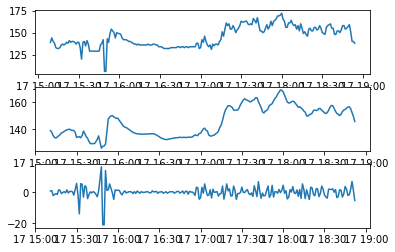

In [ ]:
plt.subplot(311)
plt.plot(df, label="Orinal")
plt.subplot(312)
plt.plot(trend,label="Trend")
plt.subplot(313)
plt.plot(residual, label="Residual")




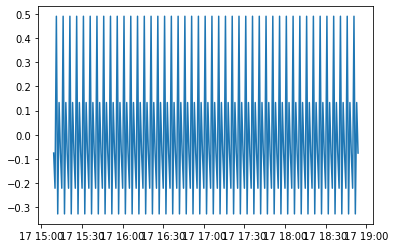

In [ ]:
plt.plot(seasonality, label="Stationarity")

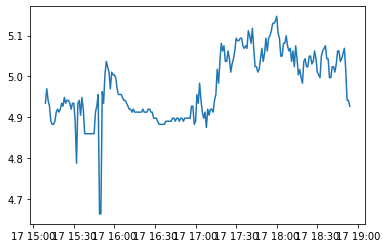

In [ ]:
df['heartrate_log'] = np.log(df)
plt.plot(df['heartrate_log'])

In [ ]:
df.head()

,Lifetouch Heart Rate,heartrate_log
Timestamp,,
2015-08-17 15:09:00,139.0,4.934474
2015-08-17 15:10:00,144.0,4.969813
2015-08-17 15:11:00,140.0,4.941642
2015-08-17 15:12:00,138.0,4.927254
2015-08-17 15:13:00,133.0,4.890349


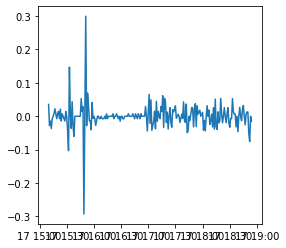

In [ ]:
plt.figure(figsize = (4,4))
df['heartrate_diff'] =df['heartrate_log'].diff(periods=1)
plt.plot(df['heartrate_diff'])

In [ ]:
df.head()

,Lifetouch Heart Rate,heartrate_log,heartrate_diff
Timestamp,,,
2015-08-17 15:09:00,139.0,4.934474,NaN
2015-08-17 15:10:00,144.0,4.969813,0.035339
2015-08-17 15:11:00,140.0,4.941642,-0.028171
2015-08-17 15:12:00,138.0,4.927254,-0.014389
2015-08-17 15:13:00,133.0,4.890349,-0.036905


In [ ]:
train = df['heartrate_diff'].iloc[:206]
test = df['heartrate_diff'].iloc[206:]

In [ ]:
model = pm.auto_arima(train.iloc[1:], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-763.911, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-743.344, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-745.053, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-750.068, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-745.292, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-764.803, Time=1.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-762.604, Time=0.59 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-765.639, Time=1.32 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-760.617, Time=0.36 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-768.523, Time=1.77 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-768.906, Time=0.57 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-767.305, Time=0.57 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-766.596, Time=1.71 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-770.764, Time=0.29 sec
 ARIMA(3,0,0)(0,0,0)[0]          

In [ ]:
model = sm.tsa.arima.ARIMA(train, order=(4,0,0))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         heartrate_diff   No. Observations:                  206
Model:                 ARIMA(4, 0, 0)   Log Likelihood                 390.453
Date:                Sun, 19 Feb 2023   AIC                           -768.906
Time:                        23:12:44   BIC                           -748.939
Sample:                    08-17-2015   HQIC                          -760.831
                         - 08-17-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.313      0.755      -0.003       0.004
ar.L1         -0.1785      0.071     -2.503      0.012      -0.318      -0.039
ar.L2         -0.3717      0.026    -14.093      0.0

In [ ]:
test

Timestamp
2015-08-17 18:35:00    0.006309
2015-08-17 18:36:00    0.006270
2015-08-17 18:37:00   -0.031749
2015-08-17 18:38:00    0.000000
2015-08-17 18:39:00   -0.046213
2015-08-17 18:40:00    0.000000
2015-08-17 18:41:00    0.026668
2015-08-17 18:42:00    0.000000
2015-08-17 18:43:00   -0.013245
2015-08-17 18:44:00    0.019803
2015-08-17 18:45:00    0.032157
2015-08-17 18:46:00    0.000000
2015-08-17 18:47:00   -0.025642
2015-08-17 18:48:00    0.006473
2015-08-17 18:49:00    0.012821
2015-08-17 18:50:00    0.012658
2015-08-17 18:51:00   -0.051624
2015-08-17 18:52:00   -0.075637
2015-08-17 18:53:00    0.000000
2015-08-17 18:54:00   -0.014389
Name: heartrate_diff, dtype: float64

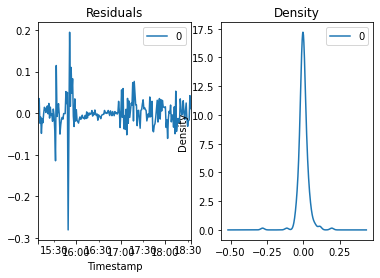

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()


In [ ]:
start = len(train)
end = len(train)+len(test)-1
pred = model_fit.predict(start = start, end = end, exog=None, dynamic=False, type='levels')

In [ ]:
pred

2015-08-17 18:35:00   -0.019093
2015-08-17 18:36:00   -0.001383
2015-08-17 18:37:00   -0.003995
2015-08-17 18:38:00    0.000251
2015-08-17 18:39:00    0.006687
2015-08-17 18:40:00    0.000154
2015-08-17 18:41:00   -0.000694
2015-08-17 18:42:00    0.000639
2015-08-17 18:43:00   -0.000402
2015-08-17 18:44:00    0.000778
2015-08-17 18:45:00    0.001079
2015-08-17 18:46:00    0.000340
2015-08-17 18:47:00    0.000535
2015-08-17 18:48:00    0.000499
2015-08-17 18:49:00    0.000401
2015-08-17 18:50:00    0.000587
2015-08-17 18:51:00    0.000549
2015-08-17 18:52:00    0.000499
2015-08-17 18:53:00    0.000535
2015-08-17 18:54:00    0.000508
Freq: T, Name: predicted_mean, dtype: float64

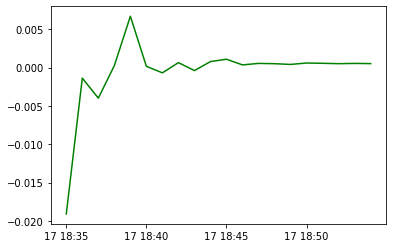

In [ ]:
plt.plot(pred, label='Prediction',color='green')

In [ ]:
df

,Lifetouch Heart Rate,heartrate_log,heartrate_diff
Timestamp,,,
2015-08-17 15:09:00,139.0,4.934474,NaN
2015-08-17 15:10:00,144.0,4.969813,0.035339
2015-08-17 15:11:00,140.0,4.941642,-0.028171
2015-08-17 15:12:00,138.0,4.927254,-0.014389
2015-08-17 15:13:00,133.0,4.890349,-0.036905
...,...,...,...
2015-08-17 18:50:00,159.0,5.068904,0.012658
2015-08-17 18:51:00,151.0,5.017280,-0.051624
2015-08-17 18:52:00,140.0,4.941642,-0.075637


In [ ]:
df['wdout_diff_heart'] = df['heartrate_diff'].cumsum()+df['heartrate_log']

In [ ]:
df['wdout_log_heartrate']=  df['wdout_diff_heart'].apply(lambda x: np.exp(x))

In [ ]:
df["wdout_diff_Prediction"] = pred.cumsum()+df['heartrate_log'].iloc[206:]

In [ ]:
df["wdout_log_Prediction"] = df["wdout_diff_Prediction"] .apply(lambda x: np.exp(x))

In [ ]:
df.tail()

,Lifetouch Heart Rate,heartrate_log,heartrate_diff,wdout_diff_heart,wdout_log_heartrate,wdout_diff_Prediction,wdout_log_Prediction
Timestamp,,,,,,,
2015-08-17 18:50:00,159.0,5.068904,0.012658,5.203334,181.877698,5.055287,156.849538
2015-08-17 18:51:00,151.0,5.017280,-0.051624,5.100086,164.035971,5.004211,149.039466
2015-08-17 18:52:00,140.0,4.941642,-0.075637,4.948811,141.007194,4.929073,138.251264
2015-08-17 18:53:00,140.0,4.941642,0.000000,4.948811,141.007194,4.929608,138.325252
2015-08-17 18:54:00,138.0,4.927254,-0.014389,4.920033,137.007194,4.915727,136.418408


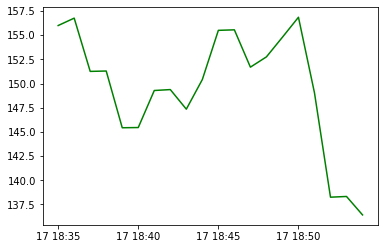

In [ ]:
plt.plot(df['wdout_log_Prediction'], label='Prediction',color='green')

In [ ]:
pred1 = df['wdout_log_Prediction'][206:]

#Building the model for the Forecasting

In [ ]:
model = sm.tsa.arima.ARIMA(df['Lifetouch Heart Rate'], order=(4,0,0)).fit()
predictions = model.forecast(20)
print(predictions)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


2015-08-17 18:55:00    138.175572
2015-08-17 18:56:00    139.044031
2015-08-17 18:57:00    139.221778
2015-08-17 18:58:00    139.403523
2015-08-17 18:59:00    139.751171
2015-08-17 19:00:00    140.024939
2015-08-17 19:01:00    140.250405
2015-08-17 19:02:00    140.487426
2015-08-17 19:03:00    140.712950
2015-08-17 19:04:00    140.918382
2015-08-17 19:05:00    141.113697
2015-08-17 19:06:00    141.299463
2015-08-17 19:07:00    141.473795
2015-08-17 19:08:00    141.638045
2015-08-17 19:09:00    141.793251
2015-08-17 19:10:00    141.939601
2015-08-17 19:11:00    142.077563
2015-08-17 19:12:00    142.207715
2015-08-17 19:13:00    142.330480
2015-08-17 19:14:00    142.446257
Freq: T, Name: predicted_mean, dtype: float64


In [ ]:
predictions.dtypes

dtype('float64')

In [ ]:
df['wdout_log_heartrate']

Timestamp
2015-08-17 15:09:00           NaN
2015-08-17 15:10:00    149.179856
2015-08-17 15:11:00    141.007194
2015-08-17 15:12:00    137.007194
2015-08-17 15:13:00    127.258993
                          ...    
2015-08-17 18:50:00    181.877698
2015-08-17 18:51:00    164.035971
2015-08-17 18:52:00    141.007194
2015-08-17 18:53:00    141.007194
2015-08-17 18:54:00    137.007194
Name: wdout_log_heartrate, Length: 226, dtype: float64

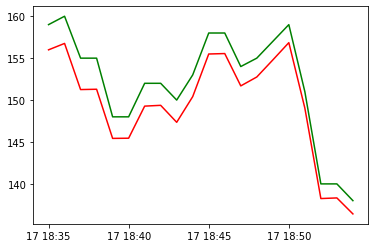

In [ ]:
plt.plot(df['Lifetouch Heart Rate'].iloc[206:], label='actual',color='green')
plt.plot(pred1, label='Prediction',color='red')

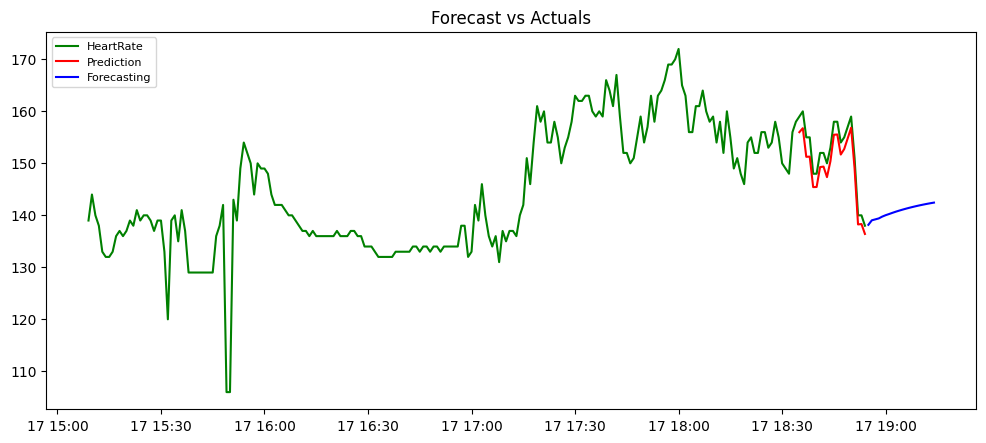

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df['Lifetouch Heart Rate'],label='HeartRate',color='green')
plt.plot(pred1, label='Prediction',color='red')
plt.plot(predictions, label='Forecasting',color='blue')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
from math import sqrt
rmse = sqrt(mean_squared_error(pred1,df['Lifetouch Heart Rate'].iloc[206:]))

In [ ]:
rmse

2.5779893530212727

In [ ]:
import json

prediction = predictions

data = []
for pred in prediction:
    data.append({'prediction': pred})

print(data[0:5])

submission_file_path = "submission.json"
with open(submission_file_path, 'w') as fp:
  fp.write('\n'.join(json.dumps(i) for i in data))
    

[{'prediction': 138.17557206414003}, {'prediction': 139.044031487723}, {'prediction': 139.22177762200488}, {'prediction': 139.40352320107422}, {'prediction': 139.75117145340676}]


#END